# Origin of gas that formed in-situ stars

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import insituFuncs as iF

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
print(h_const)

0.6774


## radial profile of gas cells that formed insitu stars

In [10]:
subhalo_id = 0
start_snap = 99

#load all star ids from a specific galaxy
star_ids = il.snapshot.loadSubhalo(basePath,start_snap,subhalo_id,'stars',fields=['ParticleIDs'])
all_star_ids = il.snapshot.loadSubset(basePath,start_snap,'stars',fields=['ParticleIDs'])

star_indices = tF.getIndices(star_ids,all_star_ids)

#determine all stars from that galaxy that were formed insitu
insitu = iF.is_insitu(basePath,star_indices,99)
insitu_star_indices = np.nonzero(insitu)
print('For subhalo {}, {} out of {} stars were formed in-Situ.'.format(subhalo_id,star_ids[insitu_star_indices].size,\
                                                                       star_ids.size))

For subhalo 0, 8330 out of 43861 stars were formed in-Situ.


In [11]:
target_snap=25
target_gas_ids, target_star_ids = tF.tracersOfSubhalo(basePath,star_ids[insitu_star_indices],start_snap,target_snap)

In [15]:
print(tF.is_unique(target_gas_ids))
print(len(np.unique(target_gas_ids)))

True
2214


In [12]:
tree = il.sublink.loadTree(basePath,start_snap,subhalo_id,fields=['SubfindID'],onlyMPB=True)
prog_id = tree[start_snap-target_snap]

com_sub = il.groupcat.loadSingle(basePath,target_snap,subhaloID=prog_id)['SubhaloCM']
all_target_gas = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['ParticleIDs','Coordinates'])

In [13]:
target_gas_coordinates = all_target_gas['Coordinates'][tF.getIndices(target_gas_ids,all_target_gas['ParticleIDs'])]

In [14]:
rad_dist = np.ones(target_gas_ids.size)
boxSize=il.groupcat.loadHeader(basePath,start_snap)['BoxSize']
for i in range(target_gas_ids.size):
    rad_dist[i] = iF.dist(com_sub,target_gas_coordinates[i],boxSize)

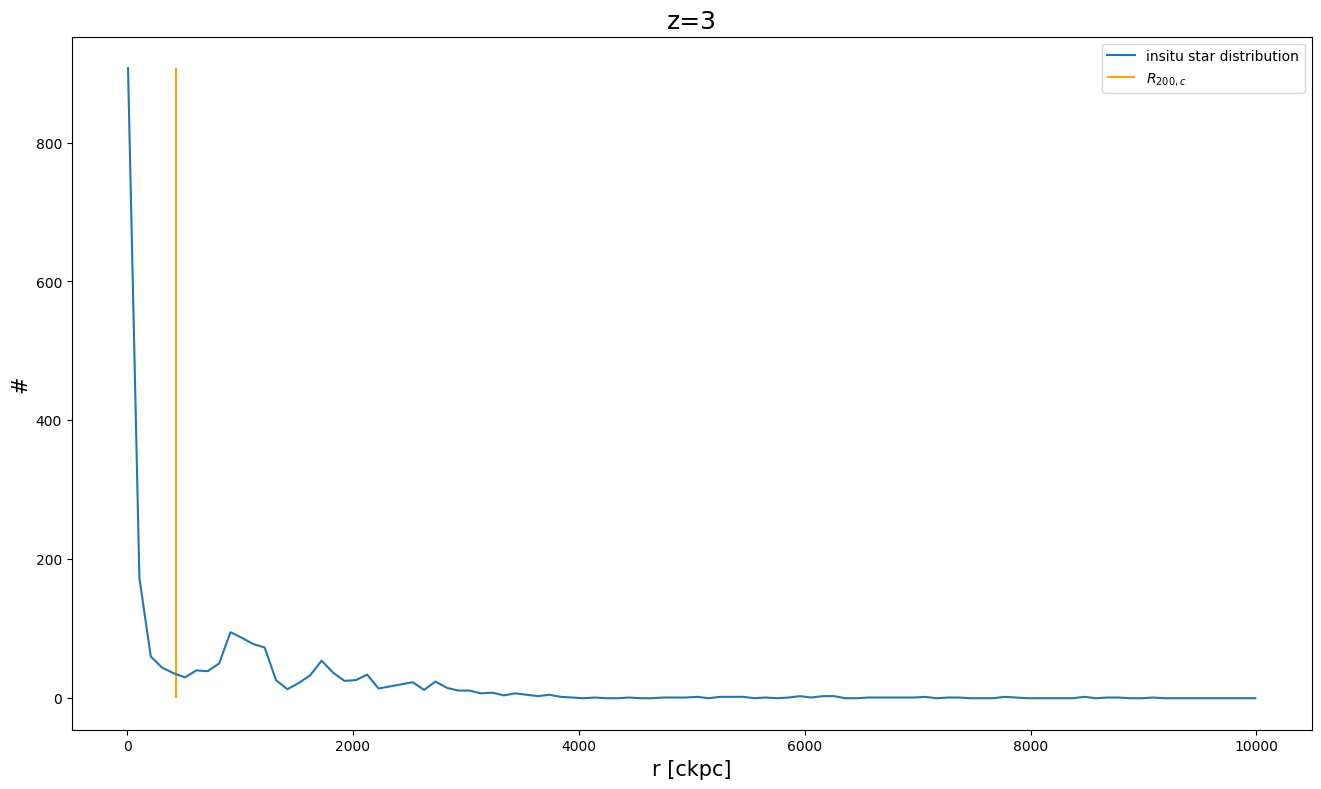

In [23]:
bins,num = iF.binData(rad_dist,100)
plt.plot(bins,num,label='insitu star distribution')

#r_shm = il.groupcat.loadSingle(basePath,target_snap,subhaloID=subhalo_id)['SubhaloHalfmassRad']
#plt.vlines(2*r_shm,0,max(num),color='orange',label='2 SHMR')

r200c = il.groupcat.loadHalos(basePath,target_snap,fields=['Group_R_Crit200'])[0]
plt.vlines(r200c,0,max(num),color='orange',label='$R_{200,c}$')

plt.legend()
plt.xlabel('r [ckpc]',size=15)
plt.ylabel('#',size=15)
plt.title('z=3',size=18)
plt.savefig(f'pics/sub{subhalo_id}_radProfile_z3_old.jpg',format='jpg')

In [10]:
print(sum(num))

2213.0


In [14]:
rad_dist_5 = insitu_gas_profile(subhalo_id,star_ids[insitu_star_indices],start_snap,10)
rad_dist_15 = insitu_gas_profile(subhalo_id,star_ids[insitu_star_indices],start_snap,15)
rad_dist_25 = insitu_gas_profile(subhalo_id,star_ids[insitu_star_indices],start_snap,25)
rad_dist_30 = insitu_gas_profile(subhalo_id,star_ids[insitu_star_indices],start_snap,30)

In [15]:
bins10,num10 = binData(rad_dist_5,100)
bins15,num15 = binData(rad_dist_15,100)
bins25,num25 = binData(rad_dist_25,100)
bins30,num30 = binData(rad_dist_30,100)
z10=il.groupcat.loadHeader(basePath,10)['Redshift']
z15=il.groupcat.loadHeader(basePath,15)['Redshift']
z25=il.groupcat.loadHeader(basePath,25)['Redshift']
z30=il.groupcat.loadHeader(basePath,30)['Redshift']

Text(0.5, 0.98, 'distribution of gas particles that form in-Situ stars')

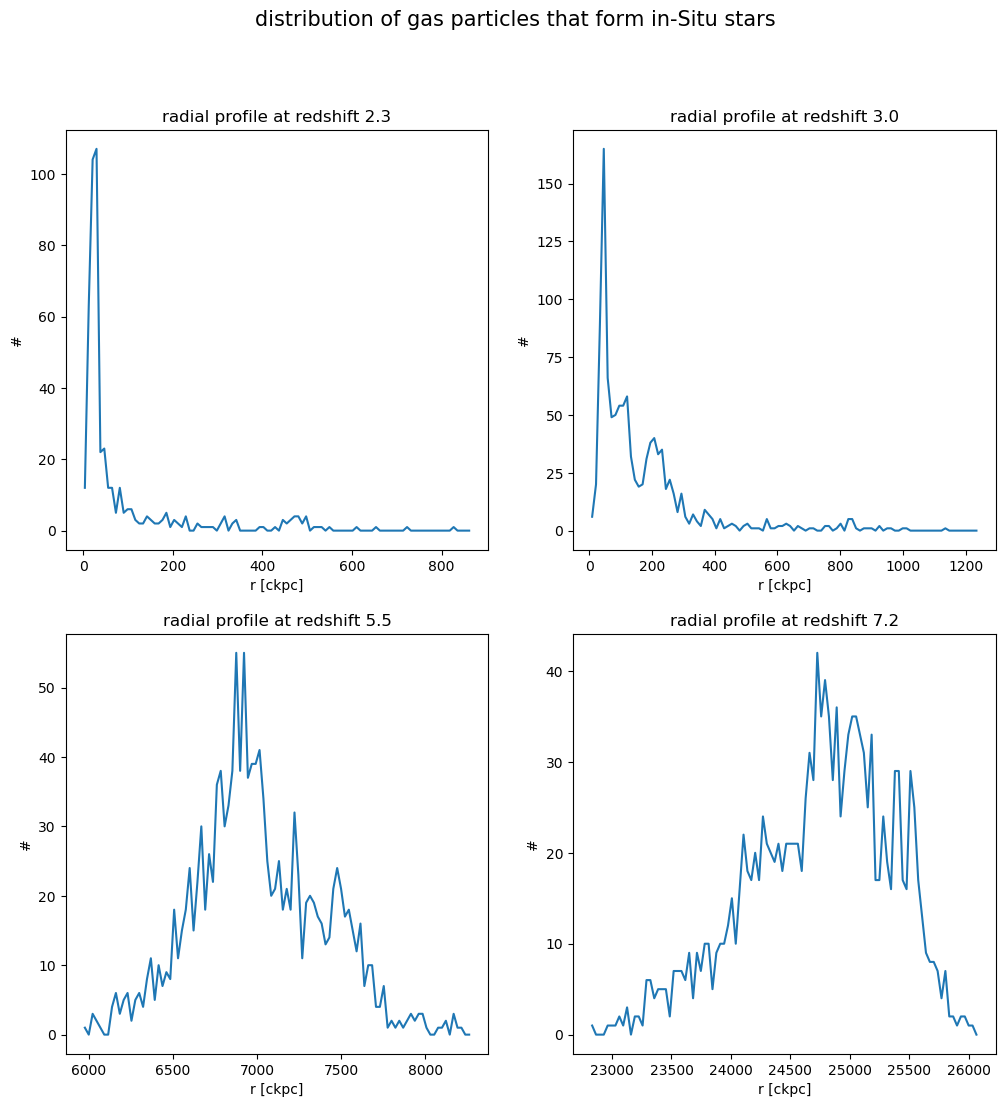

In [16]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].plot(bins30,num30)
ax[0,1].plot(bins25,num25)
ax[1,0].plot(bins15,num15)
ax[1,1].plot(bins10,num10)

ax[0,0].set(xlabel='r [ckpc]',ylabel='#',title='radial profile at redshift {:.1f}'.format(z30))
ax[0,1].set(xlabel='r [ckpc]',ylabel='#',title='radial profile at redshift {:.1f}'.format(z25))
ax[1,0].set(xlabel='r [ckpc]',ylabel='#',title='radial profile at redshift {:.1f}'.format(z15))
ax[1,1].set(xlabel='r [ckpc]',ylabel='#',title='radial profile at redshift {:.1f}'.format(z10))
fig.suptitle('distribution of gas particles that form in-Situ stars', size=15)

## try with all stars:

In [3]:
@njit(parallel=True)
def insert(arr,index,value):
    assert index<=arr.size
    out = np.zeros(arr.size+1)
    h=0
    for i in range(out.size):
        if i == index:
            out[i]=value
        else:
            out[i]=arr[h]
            h=h+1
    return out

In [4]:
#@njit(parallel=True)
def areEqual(A, B):
    n = len(A)
    if (len(B) != n):
        return False 
    # Create a hash table to count number of instances
    m = {} 
    # For each element of A increase it's instance by 1.
    for i in range(n):
        if A[i] not in m:
            m[A[i]] = 1
        else:
            m[A[i]] += 1         
    # For each element of B decrease it's instance by 1.
    for i in range(n):
        if B[i] in m:
            m[B[i]] -= 1
    # Iterate through map and check if any entry is non-zero
    for i in m:
        if (m[i] != 0):
            return False         
    return True

In [5]:
@njit
def tracersInSubhalo(StarsInSubOffset, TracersInStarOffset):
    n = StarsInSubOffset.size
    TracersInSubOffset = np.zeros(n)
    for i in nb.prange(n-1):
        TracersInSubOffset[i] = np.sum(TracersInStarOffset[StarsInSubOffset[i]:StarsInSubOffset[i+1]])
    TracersInSubOffset = np.cumsum(TracersInSubOffset)
    return TracersInSubOffset

In [6]:
#@njit
def createSortedArrays(star_ids,parent_ids,tracer_ids,StarOffsetsInSubs):
    #first determine how many tracers there are for every star
    parent_ids_copy = np.copy(parent_ids)
    parent_ids_copy = np.sort(parent_ids_copy)
    
    num_TracersPerParent = np.searchsorted(parent_ids_copy,star_ids,'right') - np.searchsorted(parent_ids_copy,star_ids,'left')
    parent_ids_offsets = np.cumsum(num_TracersPerParent)
    parent_ids_offsets = np.insert(parent_ids_offsets, 0, 0)
    
#     subIndexTemp = np.zeros(star_ids.size)
#     num_TracersPerSub = np.zeros(StarOffsetsInSubs.size-1)
#     for j in range(StarOffsetsInSubs.size-1):
#         subIndexTemp[StarOffsetsInSubs[j]:StarOffsetsInSubs[j+1]] = j
#         num_TracersPerSub[j] = np.sum(num_TracersPerParent[StarOffsetsInSubs[j]:StarOffsetsInSubs[j+1]])
#     num_TracersPerSub = np.cumsum(num_TracersPerSub)
#     num_TracersPerSub = np.insert(num_TracersPerSub, 0, 0)
    
    #create array, that has the same entries as parent_ids but sorted in a way, that all multiple entries of one ID are located
    #together, e.g. search_parents = [0,0,0,4,4,4,1,2,2,9,9,3,3,3,3,3]
    #similar array, that holds subhalo ids for every star (not necessary)
    search_parents = np.zeros(parent_ids_copy.size)
#    SubIndex = np.zeros(parent_ids_copy.size)
    for i in range(star_ids.size):
        search_parents[parent_ids_offsets[i]:parent_ids_offsets[i+1]] = star_ids[i]
#        SubIndex[parent_ids_offsets[j]:parent_ids_offsets[j+1]] = subIndexTemp[j]
        
    #find the order that would arange parent_ids in the same way search_parents would is aranged
    order = np.argsort(parent_ids)[np.argsort(np.argsort(search_parents))]
    assert( np.array_equal(parent_ids[order], search_parents) )
    
#    del subIndexTemp
    del parent_ids_copy
    
    return tracer_ids[order], parent_ids[order], num_TracersPerParent

In [7]:
@njit
def parentIndicesOfAll(parent_ids, all_gas_ids, all_star_ids): 
    #which parent corresponds to which gas/star particles?
    #for this: save index into gas('0') / star('1') subset array
    target_parent_indices = np.zeros((len(parent_ids),2))
    
    for i in range(len(parent_ids)):
        ind = np.where(parent_ids[i]==all_gas_ids)[0]
        ind2 = np.where(parent_ids[i]==all_star_ids)[0]
        if(len(ind)>0):
            target_parent_indices[i][0] = int(ind[0])
            target_parent_indices[i][1] = 0
        else:
            
            target_parent_indices[i][0] = int(ind2[0])
            target_parent_indices[i][1] = 1
    
    return target_parent_indices

In [8]:
#@jit(forceobj=True)
def TraceAllStars(basePath,star_ids, start_snap, target_snap, StarsInSubOffset):    
    all_star_ids = il.snapshot.loadSubset(basePath,start_snap,4,['ParticleIDs'])
    #load tracers at z=0
    tracers = il.snapshot.loadSubset(basePath,start_snap,3)
    tracer_ids = tracers['TracerID'].copy()
    parent_ids = tracers['ParentID'].copy()
    
    #load tracers at target snapshot
    target_tracers = il.snapshot.loadSubset(basePath,target_snap,3)
    parent_target_ids = target_tracers['ParentID']
    tracer_target_ids = target_tracers['TracerID']
    
    #load all relevant parent particles at target snapshot
    all_target_gas_ids = il.snapshot.loadSubset(basePath,target_snap,0,['ParticleIDs'])
    all_target_star_ids = il.snapshot.loadSubset(basePath,target_snap,4,['ParticleIDs'])
    
#---------------------------------------------------    
    
    #find IDs of Tracers belonging to relevant stars
    tracer_search_ids, tracer_indices = tF.findTracerIDs(star_ids,tracer_ids,parent_ids)
    
    #rearange all parent and tracer ids
    tracer_search_ids, parent_search_ids, num_tracersInParents =\
    createSortedArrays(star_ids, parent_ids[tracer_indices], tracer_ids[tracer_indices], StarsInSubOffset)
    
    #the number of tracers per subhalo can becomputed from knowing the number of tracers in every star (num_tracersInParent)
    #and the number of stars in every subhalo (StarInSubOffset)
    
    #assert(areEqual(parent_search_ids,parent_ids[tracer_indices]))
    #assert(areEqual(tracer_search_ids,tracer_ids[tracer_indices]))
    
    #get indices of relevant tracers in array of tracers in target snapshot
    tracer_target_indices = tF.getIndices(tracer_search_ids,tracer_target_ids)
    
    target_search_tracer_ids = tracer_target_ids[tracer_target_indices].copy()
    target_search_parent_ids = parent_target_ids[tracer_target_indices].copy()
    
    original_order = np.argsort(target_search_tracer_ids)[np.argsort(np.argsort(tracer_search_ids))]
    
    #sort parents as well as tracers according to sorting of parents
    target_search_tracer_ids = target_search_tracer_ids[original_order]
    target_search_parent_ids = target_search_parent_ids[original_order]
    
    assert(np.array_equal(target_search_tracer_ids,tracer_search_ids))
    
    target_parent_indices = parentIndicesOfAll(parent_ids = target_search_parent_ids, all_gas_ids = all_target_gas_ids,\
                                               all_star_ids = all_target_star_ids)
    
    
    return target_parent_indices, num_tracersInParents

In [ ]:
#define function that saves results from TraceAllStars
def TraceBackAllInsituStars(basePath,start_snap=99,target_snap):
    #load all star ids from a specific galaxy
    star_ids = il.snapshot.loadSubset(basePath,start_snap,'stars',fields=['ParticleIDs'])
    sub_coms = il.groupcat.loadSubhalos(basePath,target_snap,fields=['SubhaloCM'])

    #determine all stars from that galaxy that were formed insitu
    insitu = iF.is_insitu(basePath,np.arange(star_ids.size),99)
    insitu_star_indices = np.nonzero(insitu)[0]
    
    #load postprocessing file that contains information about offsets of stars in subhalos
    f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
    starsInSubOffset = f['Subhalo/SnapByType'][:,4]
    f.close()
    
    #calculate _inSitu_ star offsets
    check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
    insitu = np.asarray(check['InSitu'][:]==1)
    check.close()
    insituStarsInSubOffset = np.zeros(starsInSubOffset.shape[0])
    for i in range(1,starsInSubOffset.shape[0]):
        star_indices = np.arange(starsInSubOffset[i-1],starsInSubOffset[i])
        insitu_indices = insitu[star_indices]
        insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
    insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)
    
    #run function
    parent_indices, tracersInSubOffset = TraceAllStars(basePath,star_ids[insitu_star_indices],\
                                                       start_snap,target_snap,insituStarsInSubOffset)
    
    redshift = il.groupcat.loadHeader(basePath,target_snap)['Redshift']
    
    #save results in hdf5 file
    result = h5py.File('files/parent_indices_redshift_{:.1f}.hdf5'.format(redshift),'w')
    dset = result.create_dataset("parent_indices", parent_indices.shape, dtype=float)
    dset[:] = parent_indices
    dset2 = result.create_dataset('tracers_in_parents_offset',tracersInSubOffset.shape, dtype=float)
    dset2[:] = tracersInSubOffset
    result.close()
    return

In [28]:
print('{:.1f}'.format(3.141))

3.1


for every tracer, there is one parent index in the output array

In [32]:
%%time
start_snap = 99
target_snap = 25
#load all star ids from a specific galaxy
star_ids = il.snapshot.loadSubset(basePath,start_snap,'stars',fields=['ParticleIDs'])
sub_coms = il.groupcat.loadSubhalos(basePath,target_snap,fields=['SubhaloCM'])

#determine all stars from that galaxy that were formed insitu
insitu = iF.is_insitu(basePath,np.arange(star_ids.size),99)
insitu_star_indices = np.nonzero(insitu)[0]
print('In total, {} out of {} stars were formed in-Situ.'.format(star_ids[insitu_star_indices].size,star_ids.size))
 

In total, 380022 out of 605779 stars were formed in-Situ.
CPU times: user 4.46 s, sys: 128 ms, total: 4.59 s
Wall time: 5.85 s


In [33]:
#load postprocessing file that contains information about offsets of stars in subhalos
f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
starsInSubOffset = f['Subhalo/SnapByType'][:,4]
f.close()

f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(target_snap) + '.hdf5','r')
particlesInHaloOffset = f['Group/SnapByType'][:,:]
f.close()

print(starsInSubOffset.shape)
print(particlesInHaloOffset.shape)

(22869,)
(29158, 6)


In [34]:
#calculate _inSitu_ star offsets >:(
check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
insitu = np.asarray(check['InSitu'][:]==1)
check.close()
insituStarsInSubOffset = np.zeros(starsInSubOffset.shape[0])
for i in range(1,starsInSubOffset.shape[0]):
    star_indices = np.arange(starsInSubOffset[i-1],starsInSubOffset[i])
    insitu_indices = insitu[star_indices]
    insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)
print(insituStarsInSubOffset)

[     0.   8330.  10451. ... 380022. 380022. 380022.]


In [13]:
%%time
a,b=TraceAllStars(basePath,star_ids[insitu_star_indices],start_snap,target_snap,insituStarsInSubOffset)

CPU times: user 1h 53min 5s, sys: 4.77 s, total: 1h 53min 9s
Wall time: 1h 53min 4s


In [14]:
result = h5py.File('files/parent_indices_redshift_3.hdf5','w')
dset = result.create_dataset("parent_indices", a.shape, dtype=float)
dset[:]=a
dset2 = result.create_dataset('tracers_in_parents_offset',b.shape, dtype=float)
dset2[:]=b
result.close()

In [16]:
check = h5py.File('files/parent_indices_redshift_3.hdf5','r')
test = check['parent_indices'][:,:]
print(test[np.where(test[:,1]==0)[0],0].shape)
check.close()

(242809,)


In [17]:
print(starsInSubOffset)

[     0  43861  48054 ... 604978 604978 604978]


In [ ]:
print(tracersInSubhalo(starsInSubOffset,b)[:1000])

## Plot results

In [6]:
z = np.array([0.2,0.5,1.,2.,3.])
star_frac = np.zeros(z.shape)
gas_frac = np.zeros(z.shape)

In [21]:
#ratio stars - gas at z=3:
check = h5py.File('files/parent_indices_redshift_3.0.hdf5','r')
test = check['parent_indices'][:,:]
num_stars = len(test[np.where(test[:,1]==1)[0],0])
num_gas = len(test[np.where(test[:,1]==0)[0],0])
print('star - gas ratio at redshift 3: ',num_stars/num_gas)
star_frac[4] = num_stars/(num_gas+num_stars)
gas_frac[4] = num_gas/(num_gas+num_stars)
check.close()

#ratio stars - gas at z=2:
check = h5py.File('files/parent_indices_redshift_2.0.hdf5','r')
test = check['parent_indices'][:,:]
num_stars = len(test[np.where(test[:,1]==1)[0],0])
num_gas = len(test[np.where(test[:,1]==0)[0],0])
print('star - gas ratio at redshift 2: ',num_stars/num_gas)
star_frac[3] = num_stars/(num_gas+num_stars)
gas_frac[3] = num_gas/(num_gas+num_stars)
check.close()

#ratio stars - gas at z=1:
check = h5py.File('files/parent_indices_redshift_1.0.hdf5','r')
test = check['parent_indices'][:,:]
num_stars = len(test[np.where(test[:,1]==1)[0],0])
num_gas = len(test[np.where(test[:,1]==0)[0],0])
print('star - gas ratio at redshift 1: ',num_stars/num_gas)
star_frac[2] = num_stars/(num_gas+num_stars)
gas_frac[2] = num_gas/(num_gas+num_stars)
check.close()

#ratio stars - gas at z=0.5:
check = h5py.File('files/parent_indices_redshift_0.5.hdf5','r')
test = check['parent_indices'][:,:]
num_stars = len(test[np.where(test[:,1]==1)[0],0])
num_gas = len(test[np.where(test[:,1]==0)[0],0])
print('star - gas ratio at redshift 0.5: ',num_stars/num_gas)
star_frac[1] = num_stars/(num_gas+num_stars)
gas_frac[1] = num_gas/(num_gas+num_stars)
check.close()

#ratio stars - gas at z=0.2:
check = h5py.File('files/parent_indices_redshift_0.2.hdf5','r')
test = check['parent_indices'][:,:]
num_stars = len(test[np.where(test[:,1]==1)[0],0])
num_gas = len(test[np.where(test[:,1]==0)[0],0])
print('star - gas ratio at redshift 0.2: ',num_stars/num_gas)
star_frac[0] = num_stars/(num_gas+num_stars)
gas_frac[0] = num_gas/(num_gas+num_stars)
check.close()

star - gas ratio at redshift 3:  0.13480142828313613
star - gas ratio at redshift 2:  0.38358716338018267
star - gas ratio at redshift 1:  1.2707531542816644
star - gas ratio at redshift 0.5:  3.138169257340242
star - gas ratio at redshift 0.2:  8.876693669797119


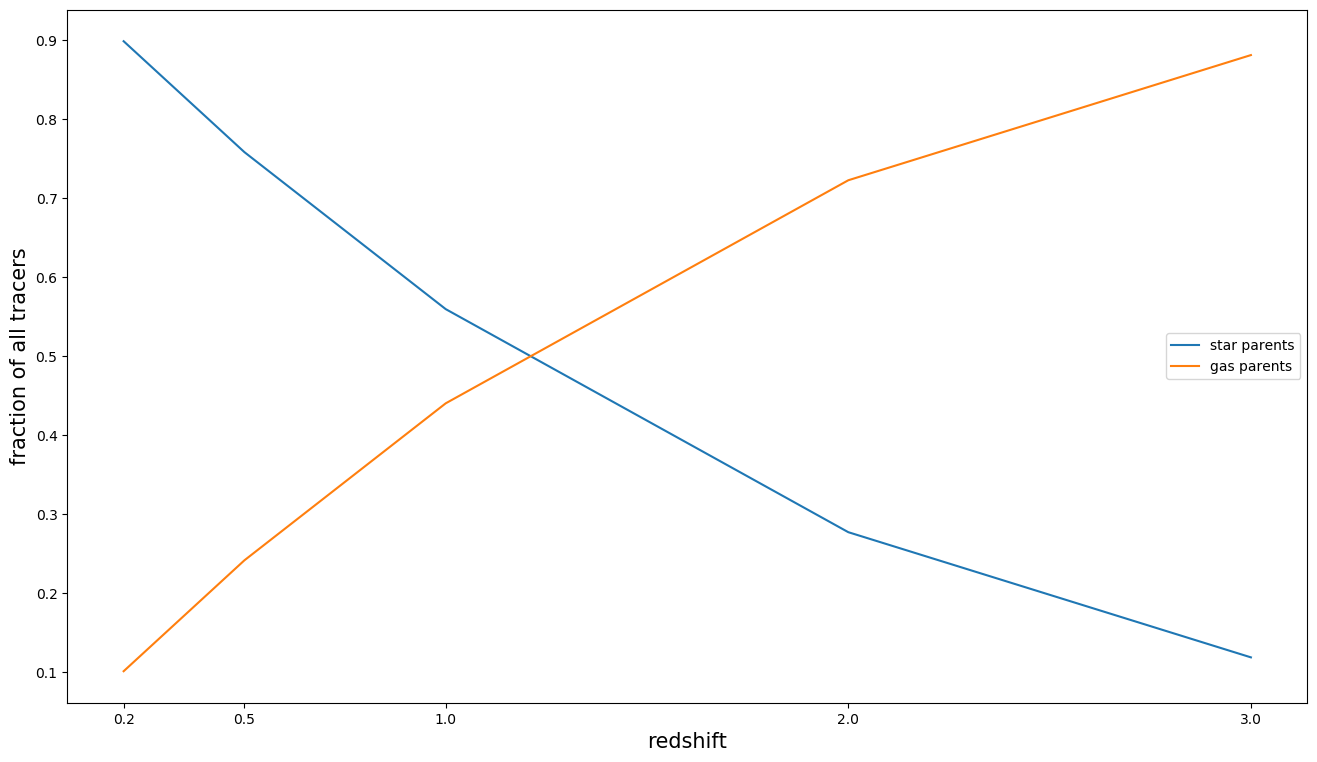

In [14]:
plt.plot(z,star_frac,label='star parents')
plt.plot(z,gas_frac,label='gas parents')
plt.xticks([0.2,0.5,1,2,3])
plt.xlabel('redshift',size=15)
plt.ylabel('fraction of all tracers',size=15)
plt.legend()

### for one subhalo:

False
4063


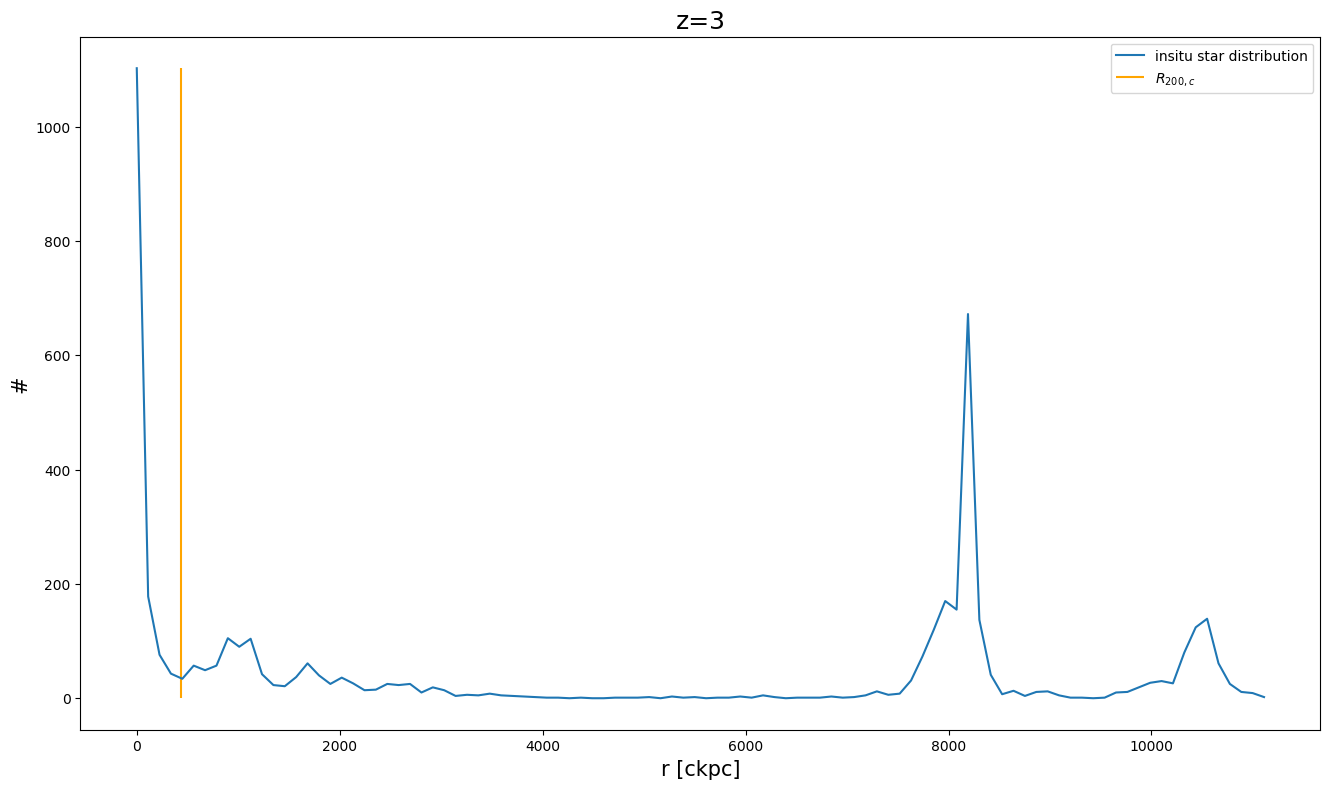

In [13]:
check = h5py.File('files/parent_indices_redshift_3.hdf5','r')
subhalo_id = 0
parent_indices = check['parent_indices'][:,:]

parent_indices_of_sub = parent_indices[int(insituStarsInSubOffset[subhalo_id]):int(insituStarsInSubOffset[subhalo_id + 1]),:]
test = parent_indices[np.where(parent_indices_of_sub[:,1]==0)[0],0]
print(tF.is_unique(test))
print(len(np.unique(test)))

all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])
gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1]==0)[0],0]
gas_pos = all_gas_pos[gas_parent_indices.astype('int')]

#load position from hdf5 file
file2 = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1_extrapolated.hdf5','r')
com_sub = file2['SubhaloPos'][subhalo_id,start_snap-target_snap,:]
file2.close()

rad_dist = np.ones(gas_pos.shape[0])
for i in range(gas_pos.shape[0]):
    rad_dist[i] = iF.dist(com_sub,gas_pos[i],boxSize)
bins, num = iF.binData(rad_dist,100)
plt.plot(bins,num,label='insitu star distribution')

r200c = il.groupcat.loadHalos(basePath,target_snap,fields=['Group_R_Crit200'])[0]
plt.vlines(r200c,0,max(num),color='orange',label='$R_{200,c}$')

#r_shm = il.groupcat.loadSingle(basePath,target_snap,subhaloID=subhalo_id)['SubhaloHalfmassRad']
#plt.vlines(2*r_shm,0,max(num),label='2 SHMR')

plt.legend()
plt.xlabel('r [ckpc]',size=15)
plt.ylabel('#',size=15)
plt.title('z=3',size=18)
check.close()
plt.savefig('pics/sub0_radProfile_z3.jpg',format='jpg')

In [9]:
print(sum(num))

4483.0


### for all subhalos:

(240378,)


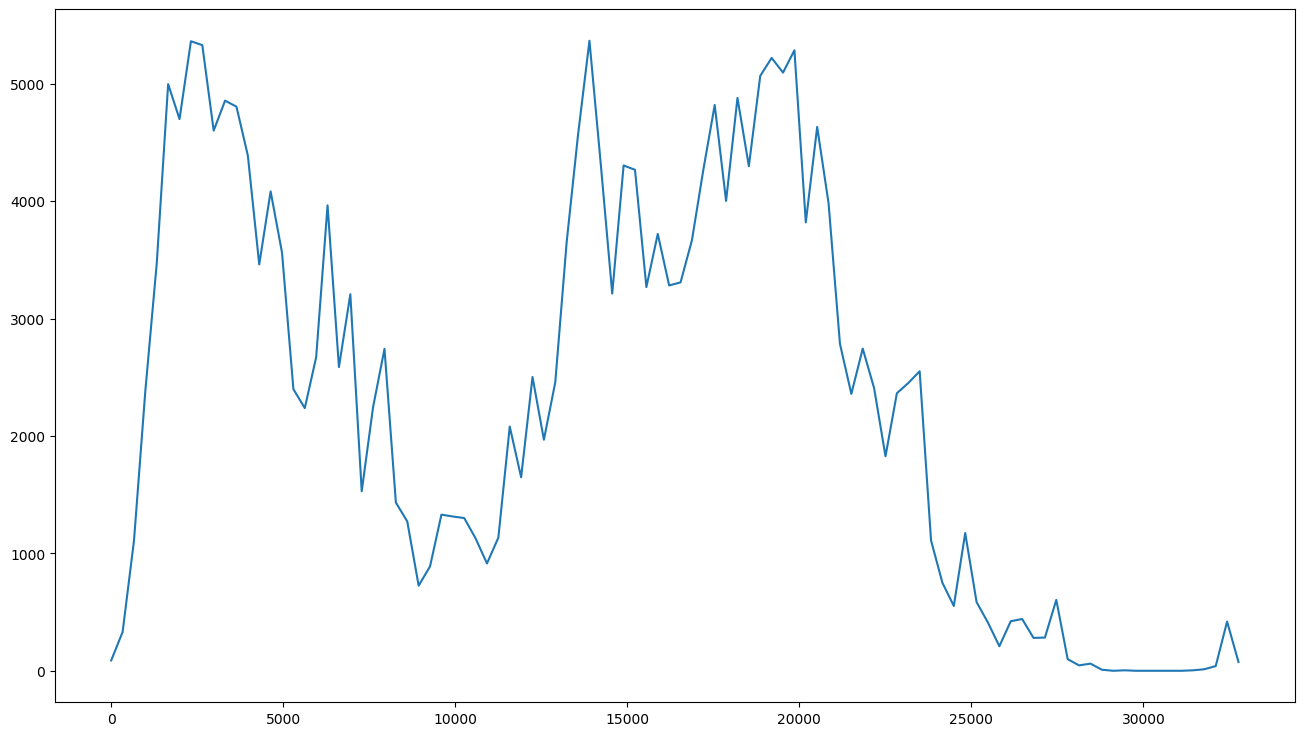

In [7]:
start_snap = 99
target_snap = 25
parent_indices = h5py.File('files/parent_indices_redshift_3.0.hdf5','r')
sub_positions = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1_extrapolated.hdf5','r') #possibly the position at that snapshot had to
                                                                                 # be extrapolated
sub_pos_at_target_snap = sub_positions['SubhaloPos'][:,:,:]
num_subs = sub_pos_at_target_snap.shape[0]

parent_indices_data = parent_indices['parent_indices'][:,:]
tracers_in_parent_offset = parent_indices['tracers_in_parents_offset'][:]

all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])

f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
starsInSubOffset = f['Subhalo/SnapByType'][:,4]
f.close()
    
check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
insitu = np.asarray(check['InSitu'][:]==1)
check.close()
insituStarsInSubOffset = np.zeros(starsInSubOffset.shape[0])
for i in range(1,starsInSubOffset.shape[0]):
    star_indices = np.arange(starsInSubOffset[i-1],starsInSubOffset[i])
    insitu_indices = insitu[star_indices]
    insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)

#there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset)
    
rad_profile = np.zeros(1)
for i in range(1,num_subs):
    parent_indices_of_sub = parent_indices_data[int(final_offsets[i-1]):int(final_offsets[i]),:]
    gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1]==0)[0],0]
    gas_pos = all_gas_pos[gas_parent_indices.astype('int')]
    
    subhalo_position = sub_pos_at_target_snap[i-1,start_snap-target_snap,:]
    
    rad_dist = np.ones(gas_pos.shape[0])
    for i in range(gas_pos.shape[0]):
        rad_dist[i] = iF.dist(subhalo_position,gas_pos[i],boxSize)
    rad_profile = np.concatenate((rad_profile,rad_dist))
        
print(rad_profile.shape)
bins, num = iF.binData(rad_profile[np.where(rad_profile<boxSize)[0]],100)
plt.plot(bins,num)

#r200c = il.groupcat.loadHalos(basePath,target_snap,fields=['Group_R_Crit200'])[0]
#plt.vlines(r200c,0,max(num),color='orange')

parent_indices.close()
sub_positions.close()

In [3]:
bins02, num02 = tF.AllTracerProfile(basePath,99,84)
bins05, num05 = tF.AllTracerProfile(basePath,99,67)
bins10, num10 = tF.AllTracerProfile(basePath,99,50)
bins20, num20 = tF.AllTracerProfile(basePath,99,33)
bins30, num30 = tF.AllTracerProfile(basePath,99,25)

(27870,)
(66537,)
(121104,)
(198341,)
(240378,)


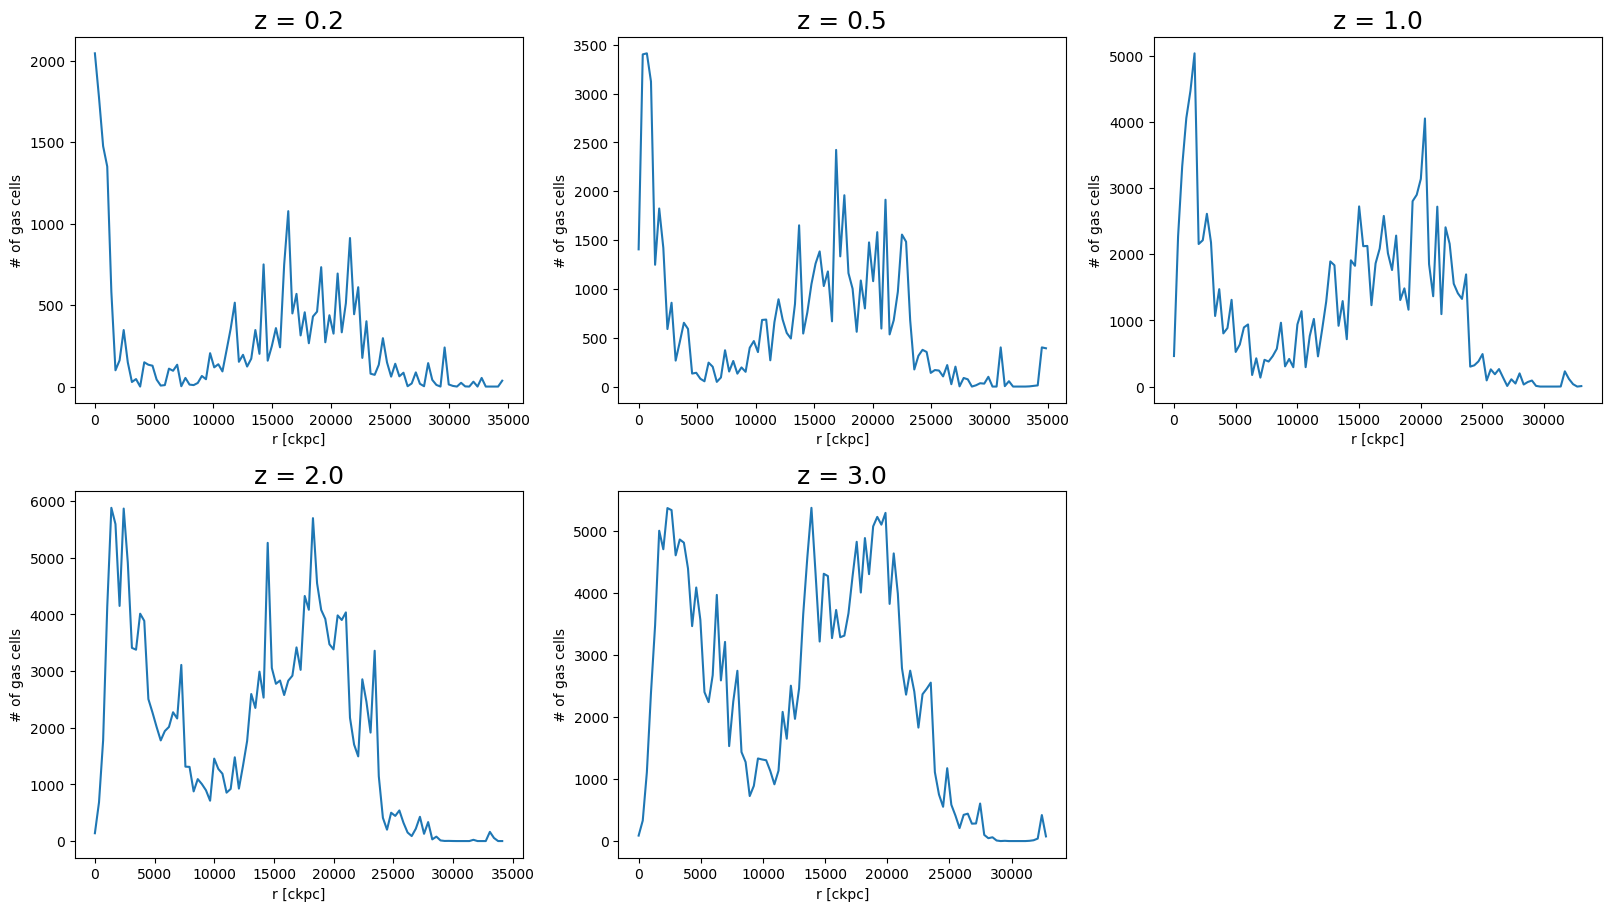

In [4]:
fig, ax = plt.subplots(2,3,constrained_layout=True)
ax[0,0].plot(bins02,num02)
ax[0,0].set_title('z = 0.2',size=18)
ax[0,1].plot(bins05,num05)
ax[0,1].set_title('z = 0.5',size=18)
ax[0,2].plot(bins10,num10)
ax[0,2].set_title('z = 1.0',size=18)
ax[1,0].plot(bins20,num20)
ax[1,0].set_title('z = 2.0',size=18)
ax[1,1].plot(bins30,num30)
ax[1,1].set_title('z = 3.0',size=18)
ax[1,2].set_visible(False)
for i in range(2):
    for j in range(3):
        ax[i,j].set(xlabel='r [ckpc]', ylabel='# of gas cells')
plt.savefig('pics/alltracerprofiles.jpg',format='jpg')

In [66]:
#20Mpc / 3000km/s
print(str(20e6*3.09e13/h_const/3000)+' s for 20 cMpc')
print(str(86400*365*1e10)+' s in 10 Gyrs')

3.0410392677886035e+17 s for 20 cMpc
3.1536e+17 s in 10 Gyrs


(27899,)


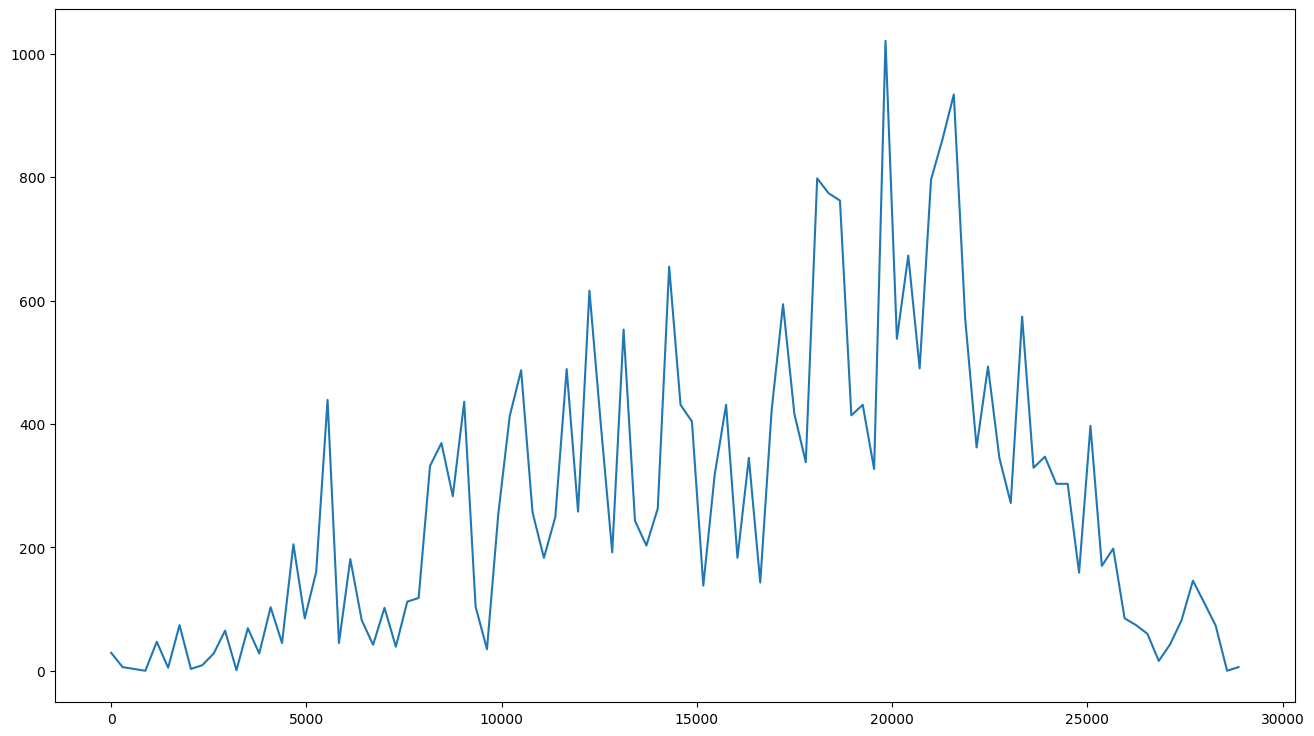

In [99]:
start_snap = 99
target_snap = 84
parent_indices = h5py.File('files/parent_indices_redshift_0.2.hdf5','r')
sub_positions = h5py.File('files/SubhaloPosAtAllSnaps_v2.hdf5','r') #possibly the position at that snapshot had to
                                                                                 # be extrapolated
sub_pos_at_target_snap = sub_positions['SubhaloPos'][:,:,:]
num_subs = sub_pos_at_target_snap.shape[0]

parent_indices_data = parent_indices['parent_indices'][:,:]
all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])

f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
starsInSubOffset = f['Subhalo/SnapByType'][:,4]
f.close()
    
check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
insitu = np.asarray(check['InSitu'][:]==1)
check.close()
insituStarsInSubOffset = np.zeros(starsInSubOffset.shape[0])
for i in range(1,starsInSubOffset.shape[0]):
    star_indices = np.arange(starsInSubOffset[i-1],starsInSubOffset[i])
    insitu_indices = insitu[star_indices]
    insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)

rad_profile = np.zeros(1)
for i in range(1,num_subs):
    parent_indices_of_sub = parent_indices_data[int(insituStarsInSubOffset[i-1]):int(insituStarsInSubOffset[i]),:]
    gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1]==0)[0],0]
    gas_pos = all_gas_pos[gas_parent_indices.astype('int')]
    
    subhalo_position = sub_pos_at_target_snap[i-1,start_snap-target_snap,:]
    
    rad_dist = np.ones(gas_pos.shape[0])
    for i in range(gas_pos.shape[0]):
        rad_dist[i] = iF.dist(subhalo_position,gas_pos[i],boxSize)
    rad_profile = np.concatenate((rad_profile,rad_dist))
        
print(rad_profile.shape)
bins, num = iF.binData(rad_profile[np.where(rad_profile<boxSize)[0]],100)
plt.plot(bins,num)

#r200c = il.groupcat.loadHalos(basePath,target_snap,fields=['Group_R_Crit200'])[0]
#plt.vlines(r200c,0,max(num),color='orange')

parent_indices.close()
sub_positions.close()

In [23]:
def AllTracerProfile_wMassBins(start_snap,target_snap):
    header = il.groupcat.loadHeader(basePath,target_snap)
    redshift = header['Redshift']
    h_const = header['HubbleParam']
    boxSize = header['BoxSize']
    
    parent_indices = h5py.File('files/parent_indices_redshift_{:.1f}.hdf5'.format(redshift),'r')
    sub_positions = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1_extrapolated_test.hdf5','r') 
    is_extrapolated = sub_positions.attrs.get('is_extrapolated')
    print(np.where(is_extrapolated==False)[0])
    #possibly, the position at that snapshot had to be extrapolated
    
    sub_pos_at_target_snap = sub_positions['SubhaloPos'][:,:,:]
    num_subs = sub_pos_at_target_snap.shape[0]

    parent_indices_data = parent_indices['parent_indices'][:,:]
    tracers_in_parent_offset = parent_indices['tracers_in_parents_offset'][:]
    
    all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])
    sub_masses = il.groupcat.loadSubhalos(basePath,start_snap,fields=['SubhaloMass']) * 1e10/h_const
    
    mass_bin1 = np.where(sub_masses<1e9)[0]
    mass_bin2 = np.where(np.logical_and(sub_masses>=1e9,sub_masses<1e10))[0]
    mass_bin3 = np.where(np.logical_and(sub_masses>=1e10,sub_masses<1e11))[0]
    mass_bin4 = np.where(np.logical_and(sub_masses>=1e11,sub_masses<1e12))[0]
    mass_bin5 = np.where(sub_masses>=1e12)[0]
    num_mass_bins = 5

    f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
    starsInSubOffset = f['Subhalo/SnapByType'][:,4]
    f.close()
    
    check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
    insitu = np.asarray(check['InSitu'][:]==1)
    check.close()
    insituStarsInSubOffset = np.zeros(starsInSubOffset.shape[0])
    for i in range(1,starsInSubOffset.shape[0]):
        star_indices = np.arange(starsInSubOffset[i-1],starsInSubOffset[i])
        insitu_indices = insitu[star_indices]
        insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
    insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)
    
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset)
    
    num_bins = 100
    bins = np.zeros((num_mass_bins,num_bins))
    num = np.zeros((num_mass_bins,num_bins))
    mass_means = np.zeros(5)
    for i in range(num_mass_bins):
        mass_rad_profile = np.zeros(1)
        for index in locals()["mass_bin"+str(i+1)]:
            if is_extrapolated[index]:
                parent_indices_of_sub = parent_indices_data[int(final_offsets[index-1]):int(final_offsets[index]),:]
                gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1]==0)[0],0]
                gas_pos = all_gas_pos[gas_parent_indices.astype('int')]
    
                subhalo_position = sub_pos_at_target_snap[index-1,start_snap-target_snap,:]
    
                rad_dist = np.ones(gas_pos.shape[0])
                for j in range(gas_pos.shape[0]):
                    rad_dist[j] = iF.dist(subhalo_position,gas_pos[j],boxSize)
                    
                mass_rad_profile = np.concatenate((mass_rad_profile,rad_dist))
                mass_rad_profile = mass_rad_profile[np.where(mass_rad_profile<boxSize)[0]]
        
        mean = np.mean(mass_rad_profile)
        mass_means[i] = mean
        bins[i,:], num[i,:] = iF.binData(mass_rad_profile,num_bins)

    for k in range(5):
        num[k,:]=num[k,:]/sum(num[k,:])
    parent_indices.close()
    sub_positions.close()
    return bins, num, mass_means

In [26]:
bins, num, mass_means = AllTracerProfile_wMassBins(99,84)

[  162   185   222 ... 22863 22867 22868]


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


In [27]:
print('z=0.2: ',mass_means)

z=0.2:  [    0.           254.56551451  1558.10745277  9261.34795697
 16426.77967927]


In [25]:
print('z=3: ',mass_means)

[    0.          6194.54836087  5050.44782135  9069.54190902
 15607.52871535]


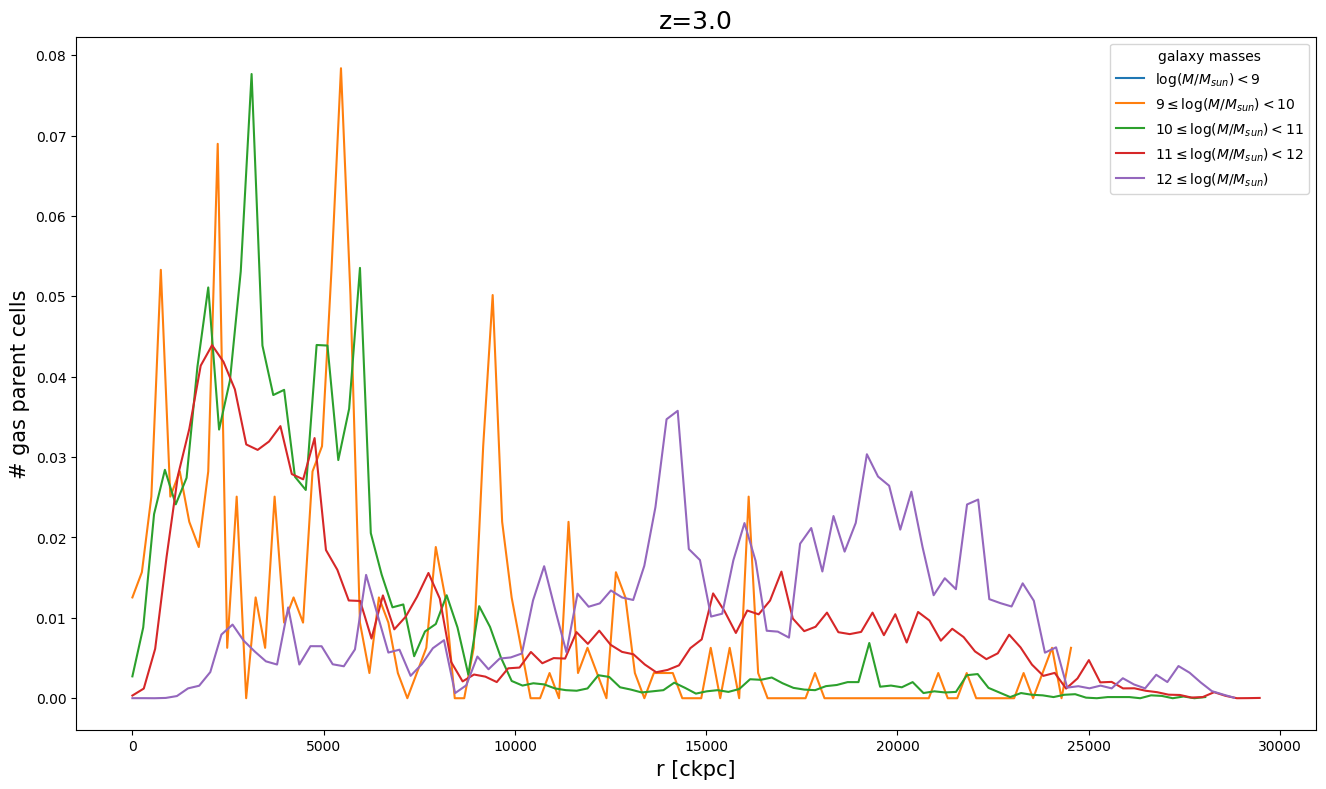

In [22]:
plt.plot(bins[0],num[0],label='$\log{(M/M_{sun})} < 9$')
plt.plot(bins[1],num[1],label='$9 \leq \log{(M/M_{sun})} < 10 $')
plt.plot(bins[2],num[2],label='$10 \leq \log{(M/M_{sun})} < 11$')
plt.plot(bins[3],num[3],label='$11 \leq \log{(M/M_{sun})} < 12 $')
plt.plot(bins[4],num[4],label='$12 \leq \log{(M/M_{sun})}$')

plt.legend(title='galaxy masses')
plt.xlabel('r [ckpc]',size=15)
plt.ylabel('# gas parent cells',size=15)
plt.title('z=3.0',size=18)
plt.savefig('pics/mass_binned_tracer_profiles_z30_normalized.jpg',format='jpg')